In [1]:
import numpy as np
import matplotlib.pyplot as plt

def eGreedy(k, rounds, epsilon, rewards, initialQ):  
    # Reward estimates for each bandit/website
    Q = np.full(k, initialQ, dtype = float)
    # Reward at specific trial 'n' for each bandit
    R = np.full(k, -1)
    # Cumulative reward for each bandit/website
    TR = np.zeros(k)
    # Counts for each bandit/website being chosen
    # Flag for optimistic case
    flag = False
    if initialQ == 0:
        n = np.zeros(k)
    else:
        n = np.ones(k)
        flag = True
    # Reward probability for each bandit (Real values unknown to the learner)
    rewardProb = rewards
    # Percentages of choice of optimal action after each round
    optimalActionRatio = np.zeros(rounds)
    # Average of total reward
    avgReward = np.zeros(rounds)
    # Total regret accumulated from experiment
    totalRegret = np.zeros(rounds)
    for i in range(rounds):
        if i == 0 and epsilon == 0:
            # First trail/iteration
            index = np.random.choice(k)
        else:
            # Random number to decide between exploration and exploitation (choice = 1 (exploit), choice = 0 (explore))
            choice = np.random.binomial(1, p = (1 - epsilon))
            # Index is used for choosing a specific bandit/website out of the available options
            index = 0
            if choice == 1:            
                # Exploit the best option
                index = np.argmax(Q)
            else:
                # Explore all bandits/websites
                index = np.random.choice(k)
        # Update the count for the chosen bandit
        n[index] += 1
        # Reward = 1 if random number > bandit reward probability else 0
        reward = np.random.binomial(1, p = rewardProb[index])
        R[index] = reward 
        # Calculate new estimate and cumulative reward for the bandit
        # Formula: Q_n+1 = Q_n + [R_n - Q_n] * (1 / n)
        Q[index] = Q[index] + (R[index] - Q[index]) / n[index]   
        # Update values for the bandit/website
        TR[index] += R[index]
        # Save ratio of optimal action being selected at each round to the total rounds that have taken place
        if flag == True:
            optimalActionRatio[i] = ((n[np.argmax(rewardProb)] - 1) / (i + 1))
        else:
            optimalActionRatio[i] = (n[np.argmax(rewardProb)] / (i + 1))
        # Update average reward
        avgReward[i] = (np.sum(TR) / np.sum(n))
        # Update total regret
        totalRegret[i] = (i + 1) - TR.sum() 
    return Q, n, TR, optimalActionRatio, avgReward, totalRegret


def UCB(k, rounds, c, rewards, initialQ):    
    # Reward estimates for each bandit/website
    Q = np.full(k, initialQ, dtype = float)
    # Reward at specific trial 'n' for each bandit
    R = np.full(k, -1)
    # UCB value storage
    A = np.zeros(k)
    # Cumulative reward for each bandit/website
    TR = np.zeros(k)
    # Counts for each bandit/website being chosen
    n = np.zeros(k)
    # Reward probability for each bandit (Real values unknown to the learner)
    rewardProb = rewards
    # Percentages of choice of optimal action after each round
    optimalActionRatio = np.zeros(rounds)
    # Average of total reward
    avgReward = np.zeros(rounds)
    # Total regret accumulated from experiment
    totalRegret = np.zeros(rounds)
    for i in range(rounds):  
        # Check for maximisizing bandits/websites
        maxIndex = np.where(n == 0)[0]
        # Check if a bandit/website hasn't been chosen even once and select it
        if len(maxIndex) >= 1:
            # Index is used for choosing a specific bandit/website out of the available options
            index = maxIndex[0]
        else:
            A = Q + np.sqrt(c * np.log(i + 1) / n)
            index = np.argmax(A)
        # Reward = 1 if random number > bandit reward probability else 0
        reward = np.random.binomial(1, p = rewardProb[index])   
        R[index] = reward
        TR[index] += R[index]
        # Update the count for the chosen bandit
        n[index] += 1
        # Average reward
        Q[index] = TR[index] / n[index]
        # Save ratio of optimal action being selected at each round to the total rounds that have taken place
        optimalActionRatio[i] = (n[np.argmax(rewardProb)] / (i + 1))
        # Update average reward
        avgReward[i] = (np.sum(TR) / (i + 1))
        # Update total regret
        totalRegret[i] = (i + 1) - TR.sum()
    return Q, n, TR, optimalActionRatio, avgReward, totalRegret


def gradientAscent(k, rounds, rewards, alpha):    
    # Possible actions
    actions = np.arange(k)
    # Learning preference for each bandit/website
    H = np.zeros(k)
    # Probabaility of choosing bandit/website at specific time 
    pieProb = np.exp(H - np.max(H)) / np.sum(np.exp(H - np.max(H)), axis = 0)
    # Reward at specific trial 'n' for each bandit
    R = np.zeros(k)
    # Cumulative reward for each bandit/website
    TR = np.zeros(k)
    # Counts for each bandit/website being chosen
    n = np.zeros(k)
    # Reward probability for each bandit (Real values unknown to the learner)
    rewardProb = rewards
    # Percentages of choice of optimal action after each round
    optimalActionRatio = np.zeros(rounds)
    # Average of total reward
    avgReward = np.zeros(rounds)
    # Total regret accumulated from experiment
    totalRegret = np.zeros(rounds)
    for i in range(rounds):
        # Choose bandit with the most probability preference
        index = np.random.choice(actions, p = pieProb)
        not_index = actions != index
        # Reward = 1 if random number > bandit reward probability else 0
        reward = np.random.binomial(1, p = rewardProb[index]) 
        R[index] = reward
        TR[index] += R[index]
        n[index] += 1
        # Update average reward
        avgReward[i] = (np.sum(TR) / (i + 1))
        # Update preference of chosen bandit/website and the rest of them
        # Formula for chosen bandit: H_t+1 = H_t + (R_t - mean(R_t) * (1 - pieProb) * alpha (alpha = stepsize)
        H[index] = H[index] + (R[index] - avgReward[i]) * (1 - pieProb[index]) * alpha
        # Formula for rest of the bandits: H_t+1 = H_t - (R_t - mean(R_t) * pieProb * alpha
        H[not_index] = H[not_index] - (R[index] - avgReward[i]) * (pieProb[not_index]) * alpha
        # Update probabilities of preference
        pieProb = np.exp(H - np.max(H)) / np.sum(np.exp(H - np.max(H)), axis = 0)
        # Save ratio of optimal action being selected at each round to the total rounds that have taken place
        optimalActionRatio[i] = (n[np.argmax(rewardProb)] / (i + 1))
        # Update total regret
        totalRegret[i] = (i + 1) - TR.sum()
    return H, n, TR, optimalActionRatio, avgReward, totalRegret

def Thompson(k, rounds, rewards):    
    # Theta values for each bandit/website
    thetas = np.zeros(k)
    # Reward at specific trial 'n' for each bandit
    R = np.full(k, -1)
    # Count for rewards = 1 for each bandit/website
    successCount = np.zeros(k)
    # Count for rewards = 0 for each bandit/website
    failCount = np.zeros(k)
    # Cumulative reward for each bandit/website
    TR = np.zeros(k)
    # Counts for each bandit/website being chosen
    n = np.zeros(k)
    # Reward probability for each bandit (Real values unknown to the learner)
    rewardProb = rewards
    # Percentages of choice of optimal action after each round
    optimalActionRatio = np.zeros(rounds)
    # Average of total reward
    avgReward = np.zeros(rounds)
    # Total regret accumulated from experiment
    totalRegret = np.zeros(rounds)
    for i in range(rounds):  
        # Calculate theta for all the actions 
        thetas = np.random.beta(successCount + 1, failCount + 1)
        # Choose highest value fo theta from all the bandits/websites
        index = np.argmax(thetas)
        # Reward = 1 if random number > bandit reward probability else 0
        reward = np.random.binomial(1, p = rewardProb[index])   
        if reward == 1:
            successCount[index] += 1
        else:
            failCount[index] += 1
        R[index] = reward
        TR[index] += R[index]
        # Update the count for the chosen bandit
        n[index] += 1
        # Save ratio of optimal action being selected at each round to the total rounds that have taken place
        optimalActionRatio[i] = (n[np.argmax(rewardProb)] / (i + 1))
        # Update average reward
        avgReward[i] = (np.sum(TR) / (i + 1))
        # Update total regret
        totalRegret[i] = (i + 1) - TR.sum()
    return n, TR, optimalActionRatio, avgReward, totalRegret


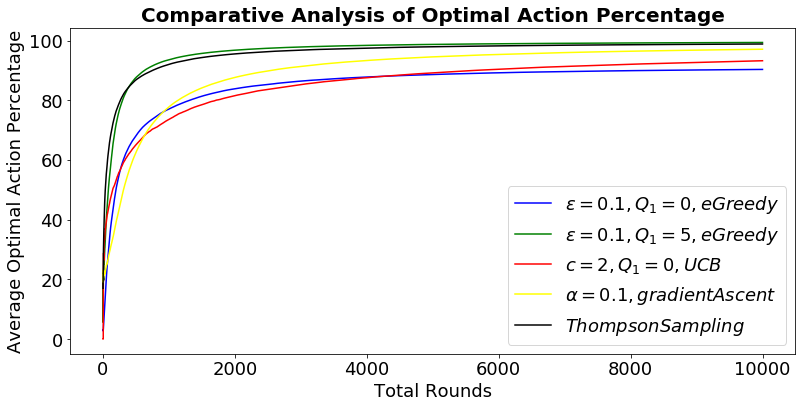

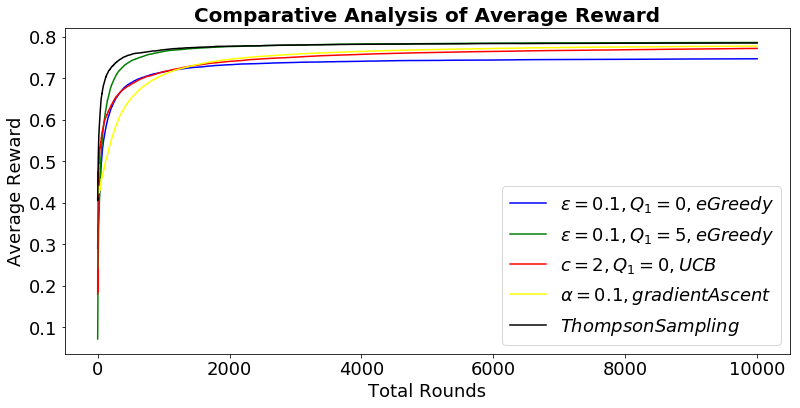

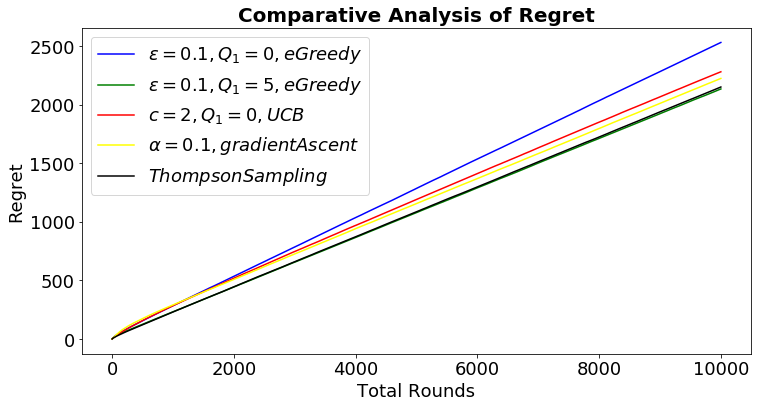

In [2]:
# Experiments Setup for all MAB techniques

experiments = 100

# Variables for experiment 1 setting (eGreedy)

rewards = [0.32, 0.245, 0.087, 0.645, 0.788]
epsilon = 0.1
initialQ = 0
rounds = 10000
k = 5

cumulativeRatios1 = np.zeros(rounds)
cumulativeAvgRewards1 = np.zeros(rounds)
cumulativeRegret1 = np.zeros(rounds)

for i in range (experiments):
    Q1, n1, TR1, Ratio1, avgRew1, tRegret1 = eGreedy(k, rounds, epsilon, rewards, initialQ)
    cumulativeRatios1 = np.add(cumulativeRatios1, Ratio1)
    cumulativeAvgRewards1 = np.add(cumulativeAvgRewards1, avgRew1)
    cumulativeRegret1 = np.add(cumulativeRegret1, tRegret1)

avgPercentage1 = (cumulativeRatios1 / experiments) * 100
avgRewards1 =  cumulativeAvgRewards1 / experiments
avgRegret1 =  cumulativeRegret1 / experiments

# Variables for experiment setting 2 (eGreedy)

epsilon = 0
initialQ = 5

cumulativeRatios2 = np.zeros(rounds)
cumulativeAvgRewards2 = np.zeros(rounds)
cumulativeRegret2 = np.zeros(rounds)

for i in range (experiments):
    Q2, n2, TR2, Ratio2, avgRew2, tRegret2 = eGreedy(k, rounds, epsilon, rewards, initialQ)
    cumulativeRatios2 = np.add(cumulativeRatios2, Ratio2)
    cumulativeAvgRewards2 = np.add(cumulativeAvgRewards2, avgRew2)
    cumulativeRegret2 = np.add(cumulativeRegret2, tRegret2)
    
avgPercentage2 = (cumulativeRatios2 / experiments) * 100
avgRewards2 = cumulativeAvgRewards2 / experiments
avgRegret2 =  cumulativeRegret2 / experiments

# Variables for experiment setting 3 (UCB)

c = 2
initialQ = 0

cumulativeRatios3 = np.zeros(rounds)
cumulativeAvgRewards3 = np.zeros(rounds)
cumulativeRegret3 = np.zeros(rounds)

for i in range (experiments):
    Q3, n3, TR3, Ratio3, avgRew3, tRegret3 = UCB(k, rounds, c, rewards, initialQ)
    cumulativeRatios3 = np.add(cumulativeRatios3, Ratio3)
    cumulativeAvgRewards3 = np.add(cumulativeAvgRewards3, avgRew3)
    cumulativeRegret3 = np.add(cumulativeRegret3, tRegret3)

avgPercentage3 = (cumulativeRatios3 / experiments) * 100
avgRewards3 =  cumulativeAvgRewards3 / experiments
avgRegret3 =  cumulativeRegret3 / experiments

# Variables for experiment setting 4 (gradientAscent)

alpha = 0.1

cumulativeRatios4 = np.zeros(rounds)
cumulativeAvgRewards4 = np.zeros(rounds)
cumulativeRegret4 = np.zeros(rounds)

for i in range (experiments):
    H4, n4, TR4, Ratio4, avgRew4, tRegret4 = gradientAscent(k, rounds, rewards, alpha)
    cumulativeRatios4 = np.add(cumulativeRatios4, Ratio4)
    cumulativeAvgRewards4 = np.add(cumulativeAvgRewards4, avgRew4)
    cumulativeRegret4 = np.add(cumulativeRegret4, tRegret4)

avgPercentage4 = (cumulativeRatios4 / experiments) * 100
avgRewards4 =  cumulativeAvgRewards4 / experiments
avgRegret4 =  cumulativeRegret4 / experiments

# Variables for experiment setting 5 (Thompson Sampling)

cumulativeRatios5 = np.zeros(rounds)
cumulativeAvgRewards5 = np.zeros(rounds)
cumulativeRegret5 = np.zeros(rounds)

for i in range (experiments):
    n5, TR5, Ratio5, avgRew5, tRegret5 = Thompson(k, rounds, rewards)
    cumulativeRatios5 = np.add(cumulativeRatios5, Ratio5)
    cumulativeAvgRewards5 = np.add(cumulativeAvgRewards5, avgRew5)
    cumulativeRegret5 = np.add(cumulativeRegret5, tRegret5)

avgPercentage5 = (cumulativeRatios5 / experiments) * 100
avgRewards5 =  cumulativeAvgRewards5 / experiments
avgRegret5 =  cumulativeRegret5 / experiments

# Comparison of Optimal Action percentage for the five experiment environments
steps = np.arange(1, rounds + 1, 1)
plt.figure(figsize = (13, 6))
plt.plot(steps, avgPercentage1, color = "blue", label = r'$\varepsilon = 0.1, Q_1 = 0, eGreedy$')
plt.plot(steps, avgPercentage2, color = "green", label = r'$\varepsilon = 0.1, Q_1 = 5, eGreedy$')
plt.plot(steps, avgPercentage3, color = "red", label = r'$c = 2, Q_1 = 0, UCB$')
plt.plot(steps, avgPercentage4, color = "yellow", label = r'$\alpha = 0.1, gradientAscent$')
plt.plot(steps, avgPercentage5, color = "black", label = r'$Thompson Sampling$')
plt.xlabel("Total Rounds", fontsize = 18)
plt.ylabel("Average Optimal Action Percentage", fontsize = 18)
plt.tick_params(labelsize = 18)
plt.title(f"Comparative Analysis of Optimal Action Percentage", fontsize = 20, fontweight = "bold")
plt.legend(fontsize = 18)
plt.savefig("OptActionPercentage.png")

# Comparison of Average Reward for the five experiment environments 
plt.figure(figsize = (13, 6))
plt.plot(steps, avgRewards1, color = "blue", label = r'$\varepsilon = 0.1, Q_1 = 0, eGreedy$')
plt.plot(steps, avgRewards2, color = "green", label = r'$\varepsilon = 0.1, Q_1 = 5, eGreedy$')
plt.plot(steps, avgRewards3, color = "red", label = r'$c = 2, Q_1 = 0, UCB$')
plt.plot(steps, avgRewards4, color = "yellow", label = r'$\alpha = 0.1, gradientAscent$')
plt.plot(steps, avgRewards5, color = "black", label = r'$Thompson Sampling$')
plt.xlabel("Total Rounds", fontsize = 18)
plt.ylabel("Average Reward", fontsize = 18)
plt.tick_params(labelsize = 18)
plt.title(f"Comparative Analysis of Average Reward", fontsize = 20, fontweight = "bold")
plt.legend(fontsize = 18)
plt.savefig("AvgReward.png")

# Comparison of Average Regret for the five experiment environments 
plt.figure(figsize = (12, 6))
plt.plot(steps, avgRegret1, color = "blue", label = r'$\varepsilon = 0.1, Q_1 = 0, eGreedy$')
plt.plot(steps, avgRegret2, color = "green", label = r'$\varepsilon = 0.1, Q_1 = 5, eGreedy$')
plt.plot(steps, avgRegret3, color = "red", label = r'$c = 2, Q_1 = 0, UCB$')
plt.plot(steps, avgRegret4, color = "yellow", label = r'$\alpha = 0.1, gradientAscent$')
plt.plot(steps, avgRegret5, color = "black", label = r'$Thompson Sampling$')
plt.xlabel("Total Rounds", fontsize = 18)
plt.ylabel("Regret", fontsize = 18)
plt.tick_params(labelsize = 18)
plt.title(f"Comparative Analysis of Regret", fontsize = 20, fontweight = "bold")
plt.legend(fontsize = 18)
plt.savefig("Regret.png")